In [228]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from IPython.display import Markdown, display

In [229]:
pd.set_option('display.float_format','{:.2f}'.format)
%matplotlib inline

In [230]:
sales = pd.read_csv('Online_Sales.csv', parse_dates=['Transaction_Date'])
customers = pd.read_excel('CustomersData.xlsx')
coupon = pd.read_csv('Discount_Coupon.csv')
marketing = pd.read_csv('Marketing_Spend.csv', parse_dates=['Date'])
tax = pd.read_excel('Tax_Amount.xlsx')

In [231]:
# Standardize cols
for df in [sales, customers, coupon, marketing, tax]:
    df.columns = df.columns.str.strip().str.lower()

In [232]:
customers.head()

,customerid,gender,location,tenure_months
0,17850,M,Chicago,12
1,13047,M,California,43
2,12583,M,Chicago,33
3,13748,F,California,30
4,15100,M,California,49


In [233]:
sales.head()

,customerid,transaction_id,transaction_date,product_sku,product_description,product_category,quantity,avg_price,delivery_charges,coupon_status
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used


In [234]:
coupon.head()

,month,product_category,coupon_code,discount_pct
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20
2,Mar,Apparel,SALE30,30
3,Jan,Nest-USA,ELEC10,10
4,Feb,Nest-USA,ELEC20,20


In [235]:
marketing.head()

,date,offline_spend,online_spend
0,2019-01-01,4500,2424.50
1,2019-01-02,4500,3480.36
2,2019-01-03,4500,1576.38
3,2019-01-04,4500,2928.55
4,2019-01-05,4500,4055.30


In [236]:
tax.head()

,product_category,gst
0,Nest-USA,0.10
1,Office,0.10
2,Apparel,0.18
3,Bags,0.18
4,Drinkware,0.18


In [237]:
# Time features
sales['transaction_date'] = pd.to_datetime(sales['transaction_date'])
sales['month'] = sales['transaction_date'].dt.to_period('M')
sales['weekday'] = sales['transaction_date'].dt.day_name()
sales['is_weekend'] = sales['weekday'].isin(['Saturday','Sunday']).astype(int)

In [238]:
# Merge coupon
coupon['month'] = pd.to_datetime('2019-' + coupon['month'], format='%Y-%b').dt.to_period('M')
coupon['product_category'] = coupon['product_category'].str.lower()
sales['product_category'] = sales['product_category'].str.lower()
sales['month'] = sales['transaction_date'].dt.to_period('M')
coupon['discount_pct'] = coupon['discount_pct'] / 100.0
sales = (
    sales
    .merge(coupon[['month','product_category','discount_pct']],
           on=['month','product_category'], how='left')
    .fillna({'discount_pct': 0})
)
sales['has_coupon'] = (sales['discount_pct']>0).astype(int)

In [239]:
# Monetary
sales['order_value'] = sales['quantity'] * sales['avg_price'] + sales['delivery_charges']
sales['net_value']   = sales['order_value'] * (1 - sales['discount_pct'])

In [240]:
# Merge tax → net_revenue
tax['product_category'] = tax['product_category'].str.lower()
sales['product_category'] = sales['product_category'].str.lower()
sales = sales.merge(tax[['product_category','gst']], on='product_category', how='left')
sales['gst_rate']   = sales['gst']/100
sales['net_revenue'] = sales['net_value']*(1+sales['gst_rate'])

In [241]:
# Merge customers & cohort
sales = sales.merge(customers, on='customerid', how='left')
sales['first_date']  = sales.groupby('customerid')['transaction_date'].transform('min')
sales['first_month'] = sales['first_date'].dt.to_period('M')
sales['cohort_period'] = (sales['month']-sales['first_month']).apply(lambda x:x.n)

In [242]:
# Monthly index
all_months = pd.period_range(sales['month'].min(), sales['month'].max(), freq='M')

## 1. Months with Highest & Lowest Acquisition Rates


Highest acquisition: 2019-01 (100.0%)
Lowest  acquisition: 2019-11 (36.2%)


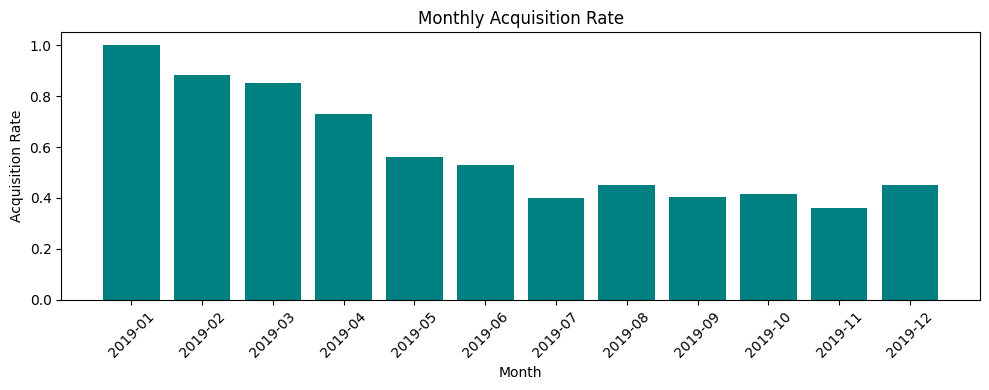

In [243]:
# 1) Get a sorted list of months as strings
months = sorted(sales['month'].unique())
month_labels = [str(m) for m in months]

# 2) Count new and total customers manually into dicts
new_cust = {}
tot_cust = {}
for m in months:
    # all orders in month m
    m_sales = sales[sales['month'] == m]
    # total unique customers that month
    tot = m_sales['customerid'].nunique()
    # new customers are those whose first_month == m
    new = m_sales[m_sales['first_month'] == m]['customerid'].nunique()
    new_cust[m] = new
    tot_cust[m] = tot

# 3) Compute acquisition rate per month manually
acq_rate = {}
for m in months:
    if tot_cust[m] > 0:
        acq_rate[m] = new_cust[m] / tot_cust[m]
    else:
        acq_rate[m] = 0.0

# 4) Find highest & lowest
rates = list(acq_rate.values())
best = months[rates.index(max(rates))]
worst = months[rates.index(min(rates))]
print(f"Highest acquisition: {best} ({acq_rate[best]:.1%})")
print(f"Lowest  acquisition: {worst} ({acq_rate[worst]:.1%})")

# 5) Plot with basic lists
plt.figure(figsize=(10,4))
# convert rates to list in order
rate_list = [acq_rate[m] for m in months]
plt.bar(month_labels, rate_list, color='teal')
plt.xticks(rotation=45)
plt.title('Monthly Acquisition Rate')
plt.xlabel('Month')
plt.ylabel('Acquisition Rate')
plt.tight_layout()
plt.show()

In [244]:
display(Markdown(f"""
- **Highest acquisition**: {best} ({acq_rate[best]:.1%}) → keep momentum with welcome bundles.  
- **Lowest  acquisition**: {worst} ({acq_rate[worst]:.1%}) → target with discount sales, promos.
"""))


- **Highest acquisition**: 2019-01 (100.0%) → keep momentum with welcome bundles.  
- **Lowest  acquisition**: 2019-11 (36.2%) → target with discount sales, promos.


## 2. Calendar‑Month New Customer Share

Top 2 months: [1, 3]
Bottom 2 months: [11, 9]


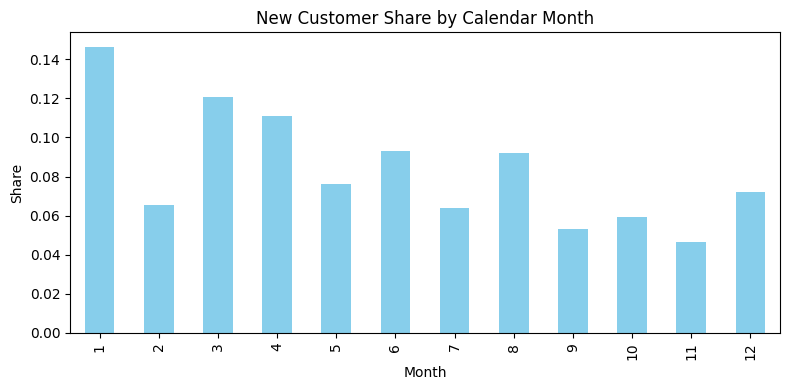

In [245]:
sales['m_num'] = sales['transaction_date'].dt.month
monthly_new = (
    sales[sales['month']==sales['first_month']]
    .groupby('m_num')['customerid'].nunique()
)
share = (monthly_new/monthly_new.sum()).reindex(range(1,13), fill_value=0)
# Print extremes
print("Top 2 months:", share.nlargest(2).index.tolist())
print("Bottom 2 months:", share.nsmallest(2).index.tolist())
# Plot
fig,ax=plt.subplots(figsize=(8,4))
share.plot(kind='bar', ax=ax, color='skyblue')
ax.set(title='New Customer Share by Calendar Month', xlabel='Month', ylabel='Share')
plt.tight_layout(); plt.show()

- More customers share is seen during the first and last month of the first quarter ie; January and March.
- Less customer share is seen during November and September.

## 3. Periods with Strongest & Weakest Retention Rates


Best: 2019-08 (69.9%), Worst: 2019-01 (0.0%)


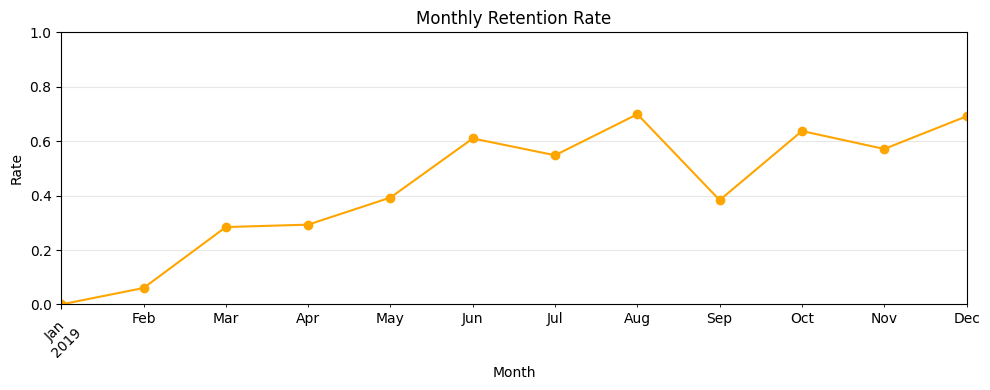

In [246]:
mon = pd.DataFrame({'new':new_cust,'total':tot_cust})
mon['returning']=mon['total']-mon['new']
mon['prev_total']=mon['total'].shift(1)
mon['retention']=(mon['returning']/mon['prev_total']).fillna(0)
best, worst = mon['retention'].idxmax(), mon['retention'].idxmin()
print(f"Best: {best} ({mon.retention.max():.1%}), Worst: {worst} ({mon.retention.min():.1%})")
# Plot
fig,ax=plt.subplots(figsize=(10,4))
mon['retention'].plot(marker='o', ax=ax, color='orange')
ax.set(title='Monthly Retention Rate', xlabel='Month', ylabel='Rate', ylim=(0,1))
plt.xticks(rotation=45); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

## 4. Behavior During High‑Retention Months


         avg_order  freq
month                   
2019-08      60.21  2414
2019-12      87.25  2684


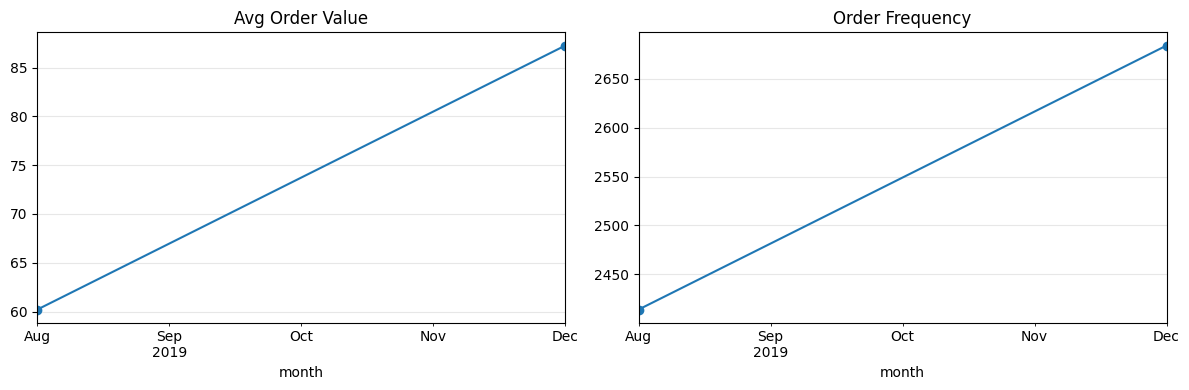

In [247]:
top2 = mon['retention'].nlargest(2).index
beh = sales[sales['month'].isin(top2)].groupby('month').agg(
    avg_order=('net_value','mean'),
    freq=('transaction_id','nunique')
)
print(beh)
fig,axes=plt.subplots(1,2,figsize=(12,4))
beh['avg_order'].plot(marker='o',ax=axes[0]); axes[0].set_title('Avg Order Value')
beh['freq'].plot(marker='o',ax=axes[1]); axes[1].set_title('Order Frequency')
for ax in axes: ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()

## 5. Revenue: New vs Existing Customers


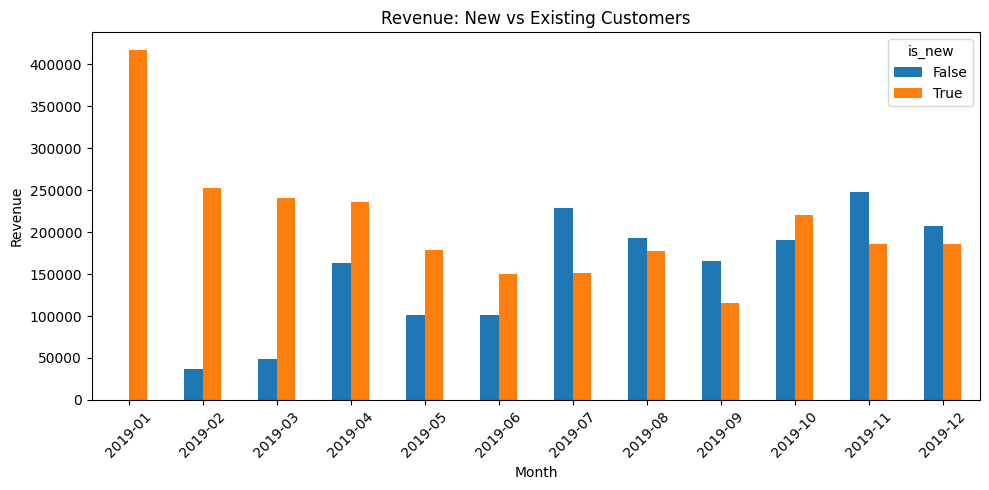

In [248]:
sales['is_new'] = sales['month']==sales['first_month']
rev_mix = (
    sales.pivot_table(index='month', columns='is_new', values='net_revenue',
                      aggfunc='sum', fill_value=0)
    .reindex(all_months, fill_value=0)
)
rev_mix.index=rev_mix.index.astype(str)
fig,ax=plt.subplots(figsize=(10,5))
rev_mix.plot(kind='bar',stacked=False, ax=ax)
ax.set(title='Revenue: New vs Existing Customers', xlabel='Month', ylabel='Revenue')
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

## 6. Coupon Usage vs Revenue Generation


In [249]:
sales['used_coupon'] = sales['discount_pct'] > 0

In [250]:
vals_coupon    = sales.loc[sales['used_coupon'],    'net_value']
vals_no_coupon = sales.loc[~sales['used_coupon'],   'net_value']

In [251]:
print(f"Orders w/ coupon:    {len(vals_coupon):,}")
print(f"Orders w/o coupon:   {len(vals_no_coupon):,}")

Orders w/ coupon:    52,524
Orders w/o coupon:   400


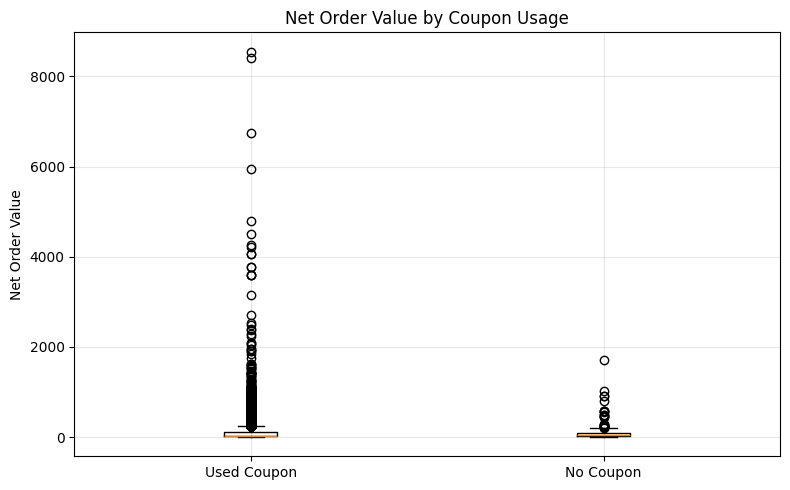

T‑test statistic = -0.63
P‑value           = 0.5296


In [252]:
fig, ax = plt.subplots(figsize=(8,5))
ax.boxplot(
    [vals_coupon, vals_no_coupon],
    tick_labels=['Used Coupon','No Coupon']
)
ax.set_title('Net Order Value by Coupon Usage')
ax.set_ylabel('Net Order Value')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 9) Welch’s t‑test
t_stat, p_val = stats.ttest_ind(vals_coupon, vals_no_coupon, equal_var=False)
print(f"T‑test statistic = {t_stat:.2f}")
print(f"P‑value           = {p_val:.4f}")

## 7. Top‑Performing Products


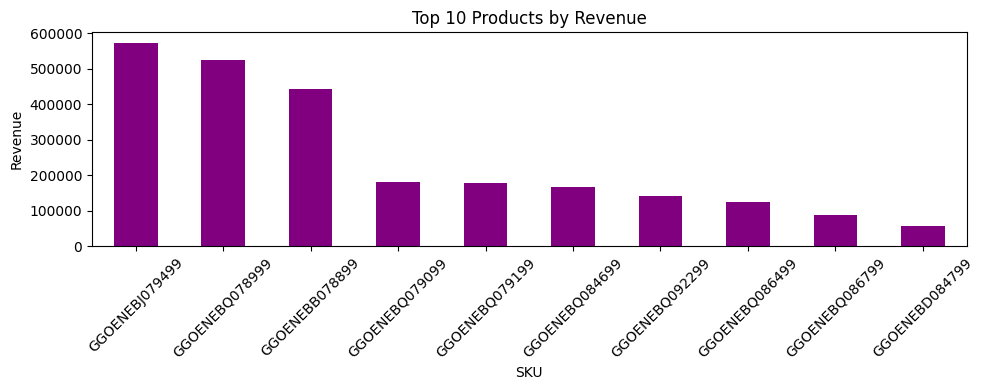

In [253]:
top10 = sales.groupby('product_sku')['net_revenue'].sum().nlargest(10)
fig,ax=plt.subplots(figsize=(10,4))
top10.plot(kind='bar',ax=ax,color='purple')
ax.set(title='Top 10 Products by Revenue',xlabel='SKU',ylabel='Revenue')
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

## 8. Marketing Spend vs Revenue (ROI)


Index(['revenue', 'offline_spend', 'online_spend', 'total_spend', 'ROI'], dtype='object')
          revenue  offline_spend  online_spend  total_spend  ROI
2019-01 417404.87          96600      58328.95    154928.95 2.69
2019-02 289033.10          81300      55807.92    137107.92 2.11
2019-03 289267.14          73500      48750.09    122250.09 2.37
2019-04 399821.48          96000      61026.83    157026.83 2.55
2019-05 280568.54          65500      52759.64    118259.64 2.37
Lowest ROI Month: 2019-06, Highest ROI Month: 2019-07


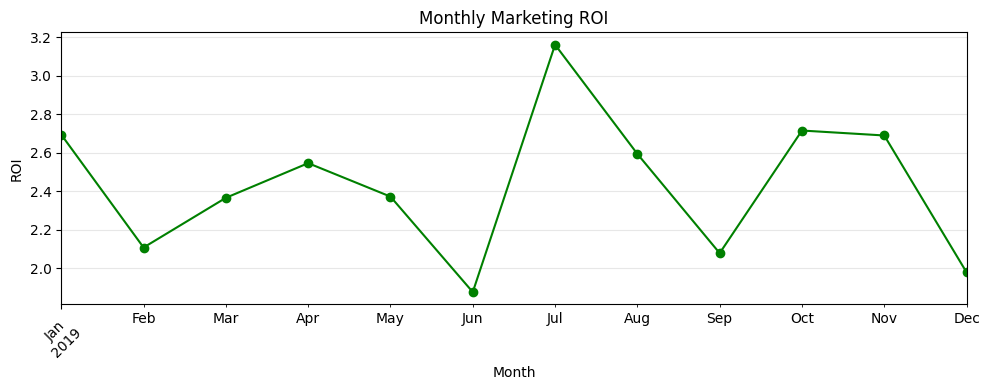

In [254]:
# 1) Define full 2019 month index
all_months = pd.period_range(sales['month'].min(), sales['month'].max(), freq='M')

# 2) Aggregate sales into `mon` with an explicit `revenue` column
mon = (
    sales
    .groupby('month')
    .agg(revenue=('net_revenue','sum'))
    .reindex(all_months, fill_value=0)
)

# 3) Prepare marketing spend by month
marketing['month'] = marketing['date'].dt.to_period('M')
spend = (
    marketing
    .groupby('month')[['offline_spend','online_spend']]
    .sum()
    .reindex(all_months, fill_value=0)
)

# 4) Join spend into mon and compute ROI
mon = mon.join(spend)
mon['total_spend'] = mon['offline_spend'] + mon['online_spend']
mon['ROI'] = mon['revenue'] / mon['total_spend'].replace(0, np.nan)

# 5) Inspect to confirm
print(mon.columns)
print(mon.head())

# 6) Identify low/high ROI
low_roi, high_roi = mon['ROI'].idxmin(), mon['ROI'].idxmax()
print(f"Lowest ROI Month: {low_roi}, Highest ROI Month: {high_roi}")

# 7) Plot
fig, ax = plt.subplots(figsize=(10,4))
mon['ROI'].plot(marker='o', ax=ax, color='green')
ax.set(title='Monthly Marketing ROI', xlabel='Month', ylabel='ROI')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Campaign Effectiveness: Spend vs Revenue


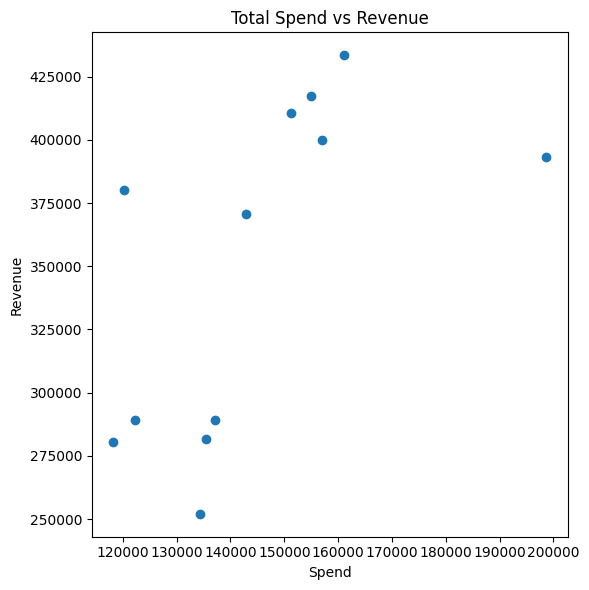

Corr with offline: 0.5826191531601633
Corr with online: 0.6255940407741278


In [255]:
fig,ax=plt.subplots(figsize=(6,6))
ax.scatter(mon['total_spend'], mon['revenue'])
ax.set(title='Total Spend vs Revenue',xlabel='Spend',ylabel='Revenue')
plt.tight_layout(); plt.show()
print("Corr with offline:",mon['revenue'].corr(mon['offline_spend']))
print("Corr with online:", mon['revenue'].corr(mon['online_spend']))

## 10–11. RFM Segmentation & Revenue Contribution


/var/folders/92/bm_nyn89101fck1f72xms5fw0000gn/T/ipykernel_24174/1797263366.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('tier')['rev'].sum()


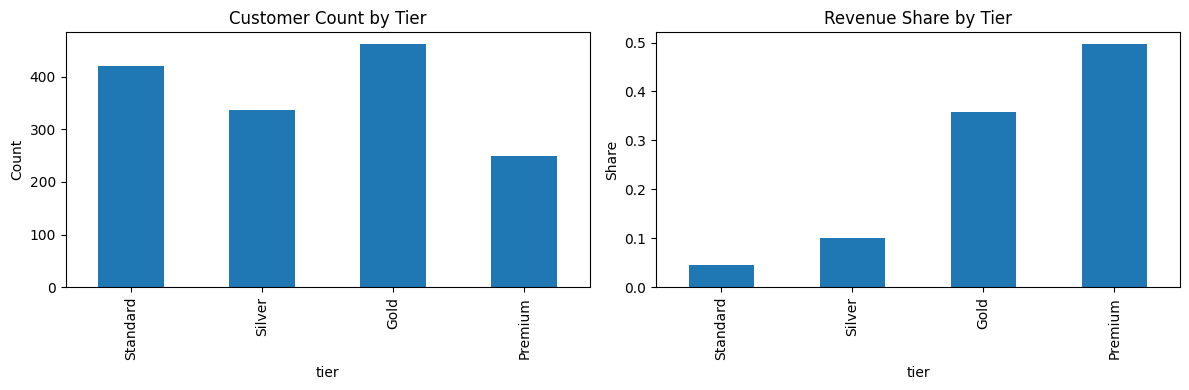

In [256]:
today = sales['transaction_date'].max() + pd.Timedelta(days=1)

rfm = (
    sales
    .groupby('customerid')
    .agg(
        recency  = ('transaction_date', lambda x: (today - x.max()).days),
        frequency= ('transaction_id',  'nunique'),
        monetary = ('net_revenue',     'sum')
    )
)

rfm['r_q']   = pd.qcut(rfm['recency'],   4, labels=[4,3,2,1])
rfm['f_q']   = pd.qcut(rfm['frequency'], 4, labels=[1,2,3,4])
rfm['m_q']   = pd.qcut(rfm['monetary'],  4, labels=[1,2,3,4])
rfm['score'] = rfm[['r_q','f_q','m_q']].sum(axis=1)
rfm['tier']  = pd.qcut(rfm['score'],     4, labels=['Standard','Silver','Gold','Premium'])

# …and then your customer‑count and revenue‑share plots:
cust_count = rfm['tier'].value_counts().sort_index()
rev_by_cust = sales.groupby('customerid')['net_revenue'].sum().rename('rev')
share = rev_by_cust.to_frame().merge(rfm['tier'], left_index=True, right_index=True) \
                    .groupby('tier')['rev'].sum()

fig, axes = plt.subplots(1,2,figsize=(12,4))
cust_count.plot(kind='bar', ax=axes[0], title='Customer Count by Tier')
(share/share.sum()).plot(kind='bar', ax=axes[1], title='Revenue Share by Tier')
axes[0].set_ylabel('Count')
axes[1].set_ylabel('Share')
plt.tight_layout()
plt.show()

## 12. Cohort Retention Heatmap


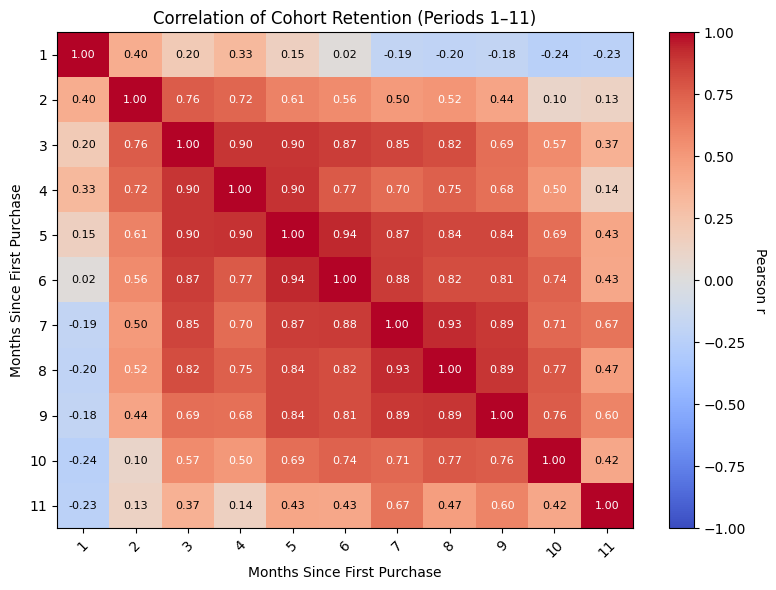

In [257]:
# 1) Assume cohort_norm is your retention‐rate DF with columns [0,1,2,…]
# Drop the zero-period (first purchase) column
ret_corr = cohort_norm.drop(columns=0).corr()

# 2) Plot the corrected correlation matrix
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(ret_corr, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')

# ticks & labels
months = ret_corr.columns
ax.set_xticks(np.arange(len(months)))
ax.set_yticks(np.arange(len(months)))
ax.set_xticklabels(months, rotation=45)
ax.set_yticklabels(months)

# annotate
for i in range(len(months)):
    for j in range(len(months)):
        val = ret_corr.iat[i,j]
        ax.text(j, i, f'{val:.2f}',
                ha='center', va='center',
                color='white' if abs(val)>0.5 else 'black',
                fontsize=8)

# colorbar & titles
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Pearson r', rotation=270, labelpad=15)
ax.set_title('Correlation of Cohort Retention (Periods 1–11)')
ax.set_xlabel('Months Since First Purchase')
ax.set_ylabel('Months Since First Purchase')
plt.tight_layout()
plt.show()


## 13. Lifetime Value Curves by Cohort


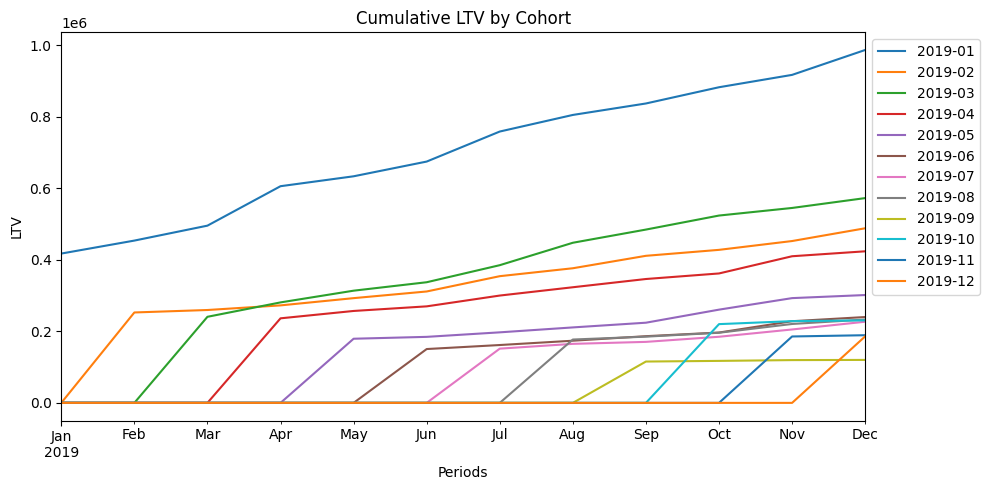

In [258]:
cum_rev = (sales.groupby(['first_month','month'])['net_revenue']
           .sum().groupby(level=0).cumsum().unstack(fill_value=0))
fig,ax=plt.subplots(figsize=(10,5))
cum_rev.T.plot(ax=ax)
ax.set(title='Cumulative LTV by Cohort',xlabel='Periods',ylabel='LTV')
plt.legend(bbox_to_anchor=(1,1)); plt.tight_layout(); plt.show()

## 14. Coupon AOV Test  


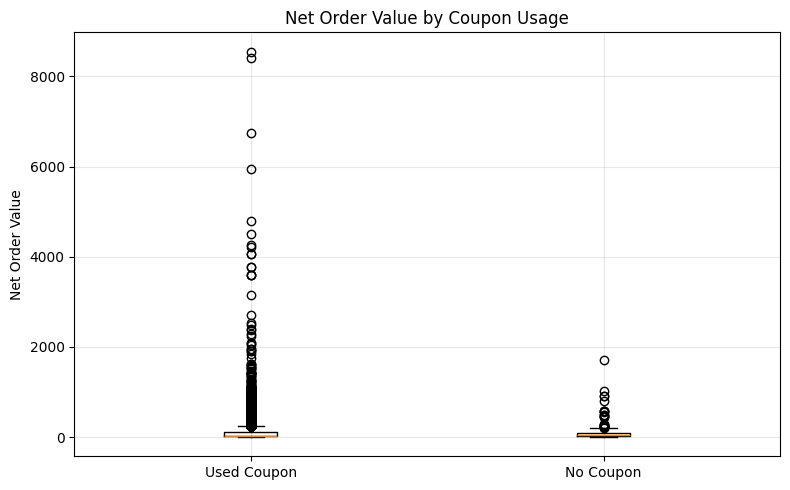

T‑test statistic = -0.63
P‑value           = 0.5296


In [259]:
fig, ax = plt.subplots(figsize=(8,5))
ax.boxplot(
    [vals_coupon, vals_no_coupon],
    tick_labels=['Used Coupon','No Coupon']
)
ax.set_title('Net Order Value by Coupon Usage')
ax.set_ylabel('Net Order Value')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 9) Welch’s t‑test
t_stat, p_val = stats.ttest_ind(vals_coupon, vals_no_coupon, equal_var=False)
print(f"T‑test statistic = {t_stat:.2f}")
print(f"P‑value           = {p_val:.4f}")

## 15. Do purchase behaviors (e.g., order frequency, order value) vary significantly across different demographic groups or pricing factors (e.g., delivery charges)?

Location ANOVA – Frequency: F=1.60, p=0.1723
Location ANOVA – AOV:       F=1.59, p=0.1748


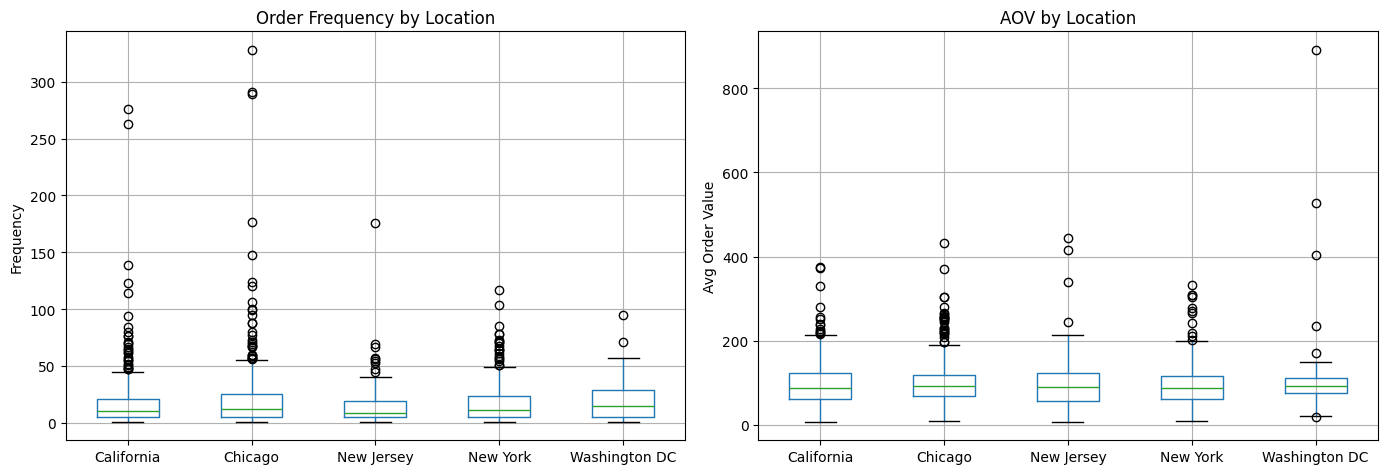

Tenure ANOVA – Frequency: F=0.98, p=0.4005
Tenure ANOVA – AOV:       F=1.08, p=0.3558


/var/folders/92/bm_nyn89101fck1f72xms5fw0000gn/T/ipykernel_24174/2974909486.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups_ten_freq = [g['frequency'].values for _, g in cust_metrics.groupby('tenure_bin')]
/var/folders/92/bm_nyn89101fck1f72xms5fw0000gn/T/ipykernel_24174/2974909486.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups_ten_aov  = [g['aov'].values       for _, g in cust_metrics.groupby('tenure_bin')]


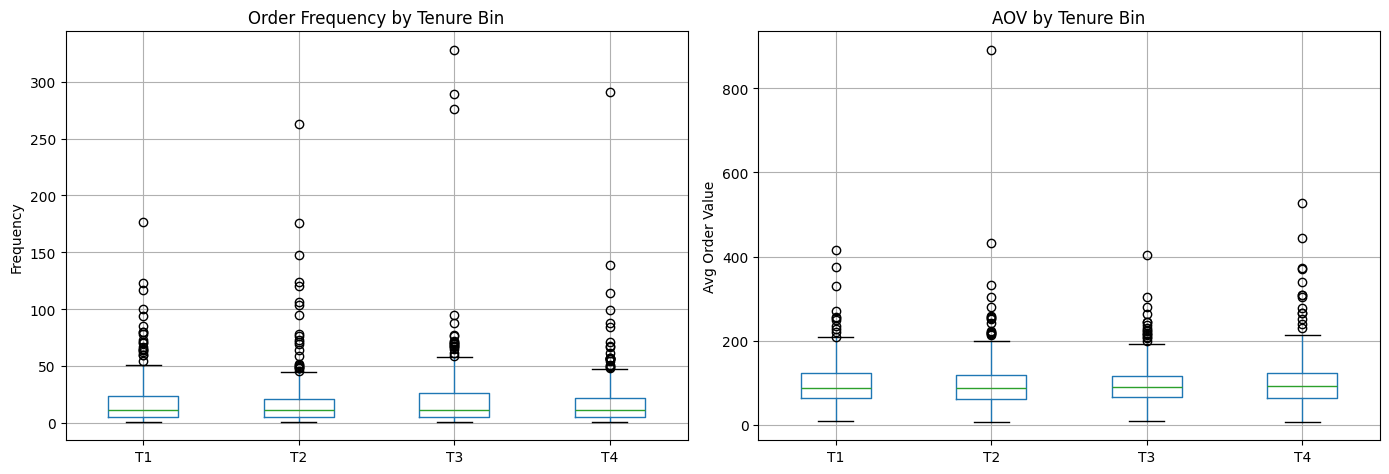

Delivery‑Charge ANOVA – Order Value: F=256.08, p=0.0000


/var/folders/92/bm_nyn89101fck1f72xms5fw0000gn/T/ipykernel_24174/2974909486.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups_del = [g['order_value'].values for _, g in sales_1.groupby('del_bin')]


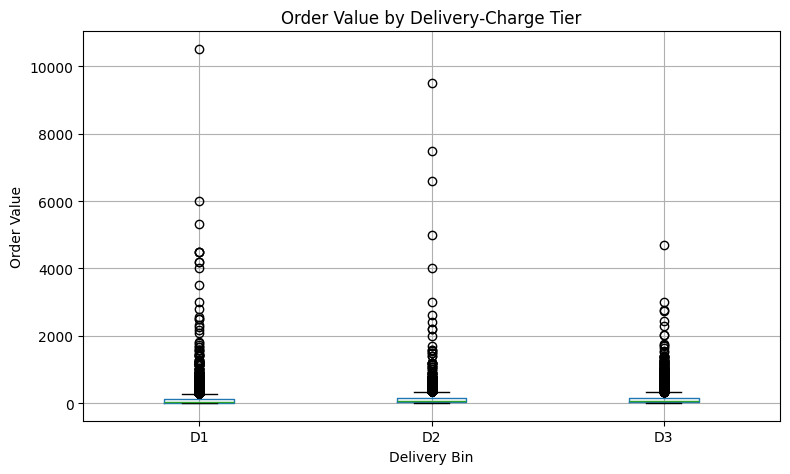

In [260]:
# 1) Load & normalize column names
sales_1 = pd.read_csv('Online_Sales.csv', parse_dates=['Transaction_Date'])
customers_1 = pd.read_excel('CustomersData.xlsx')
sales_1.columns = sales_1.columns.str.lower().str.strip()
customers_1.columns = customers_1.columns.str.lower().str.strip()

# 2) Feature: per‑order value
sales_1['order_value'] = sales_1['quantity'] * sales_1['avg_price'] + sales_1['delivery_charges']

# 3) Merge in demographics
sales_1 = sales_1.merge(customers_1, on='customerid', how='left')

# 4) Build per‑customer metrics
cust_metrics = (
    sales_1
    .groupby('customerid')
    .agg(
        frequency=('transaction_id','nunique'),
        aov=('order_value','mean'),
        tenure=('tenure_months','first'),
        location=('location','first')
    )
    .reset_index()
)

# 5) ANOVA & Boxplots by Location
groups_loc_freq = [g['frequency'].values for _, g in cust_metrics.groupby('location')]
groups_loc_aov  = [g['aov'].values for _, g in cust_metrics.groupby('location')]
f_loc_freq, p_loc_freq = stats.f_oneway(*groups_loc_freq)
f_loc_aov,  p_loc_aov  = stats.f_oneway(*groups_loc_aov)
print(f"Location ANOVA – Frequency: F={f_loc_freq:.2f}, p={p_loc_freq:.4f}")
print(f"Location ANOVA – AOV:       F={f_loc_aov:.2f}, p={p_loc_aov:.4f}")

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
cust_metrics.boxplot('frequency', by='location', ax=ax1)
ax1.set(title='Order Frequency by Location', xlabel='', ylabel='Frequency')
cust_metrics.boxplot('aov', by='location', ax=ax2)
ax2.set(title='AOV by Location',       xlabel='', ylabel='Avg Order Value')
plt.suptitle(''); plt.tight_layout(); plt.show()

# 6) ANOVA & Boxplots by Tenure Bin
cust_metrics['tenure_bin'] = pd.qcut(
    cust_metrics['tenure'], 
    q=4, 
    labels=['T1','T2','T3','T4'], 
    duplicates='drop'
)
groups_ten_freq = [g['frequency'].values for _, g in cust_metrics.groupby('tenure_bin')]
groups_ten_aov  = [g['aov'].values       for _, g in cust_metrics.groupby('tenure_bin')]
f_ten_freq, p_ten_freq = stats.f_oneway(*groups_ten_freq)
f_ten_aov,  p_ten_aov  = stats.f_oneway(*groups_ten_aov)
print(f"Tenure ANOVA – Frequency: F={f_ten_freq:.2f}, p={p_ten_freq:.4f}")
print(f"Tenure ANOVA – AOV:       F={f_ten_aov:.2f}, p={p_ten_aov:.4f}")

fig, (ax3,ax4) = plt.subplots(1,2,figsize=(14,5))
cust_metrics.boxplot('frequency', by='tenure_bin', ax=ax3)
ax3.set(title='Order Frequency by Tenure Bin', xlabel='', ylabel='Frequency')
cust_metrics.boxplot('aov', by='tenure_bin', ax=ax4)
ax4.set(title='AOV by Tenure Bin', xlabel='', ylabel='Avg Order Value')
plt.suptitle(''); plt.tight_layout(); plt.show()

# 7) ANOVA & Boxplot by Delivery‑Charge Tier
_, edges = pd.qcut(
    sales_1['delivery_charges'], 
    q=4, 
    retbins=True, 
    duplicates='drop'
)
labels = [f"D{i+1}" for i in range(len(edges)-1)]
sales_1['del_bin'] = pd.cut(
    sales_1['delivery_charges'], 
    bins=edges, 
    labels=labels, 
    include_lowest=True
)
groups_del = [g['order_value'].values for _, g in sales_1.groupby('del_bin')]
f_del, p_del = stats.f_oneway(*groups_del)
print(f"Delivery‑Charge ANOVA – Order Value: F={f_del:.2f}, p={p_del:.4f}")

fig, ax5 = plt.subplots(figsize=(8,5))
sales_1.boxplot('order_value', by='del_bin', ax=ax5)
ax5.set(title='Order Value by Delivery‑Charge Tier', xlabel='Delivery Bin', ylabel='Order Value')
plt.suptitle(''); plt.tight_layout(); plt.show()


## 16. Purchase Behavior: Demographics & Delivery Charges


Location ANOVA p=0.0302, Delivery t-test p=0.0000


/var/folders/92/bm_nyn89101fck1f72xms5fw0000gn/T/ipykernel_24174/559130430.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(groups_loc,labels=sales['location'].unique()); ax1.set_title('Order Value by Location')
/var/folders/92/bm_nyn89101fck1f72xms5fw0000gn/T/ipykernel_24174/559130430.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(group_d,labels=['Low Del','High Del']); ax2.set_title('Order Value by Delivery Tier')


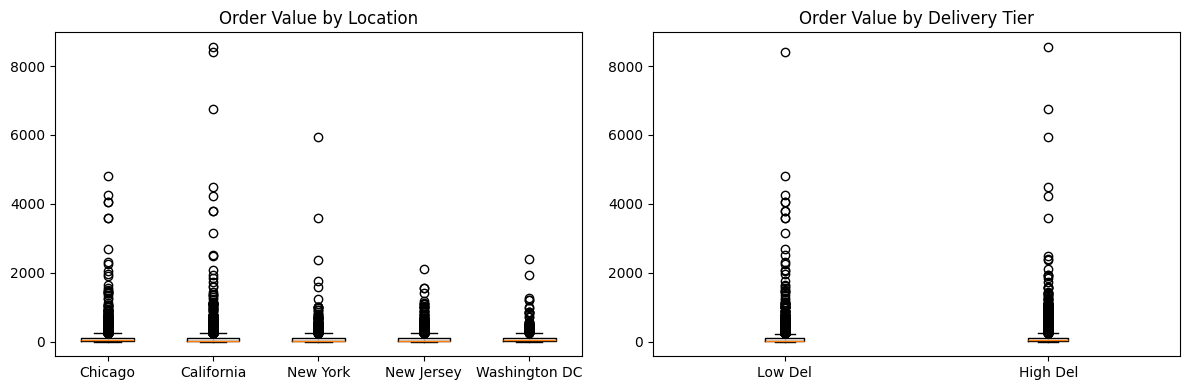

In [261]:
# ANOVA location
groups_loc=[g['net_value'].values for _,g in sales.groupby('location')]
f,p_loc=stats.f_oneway(*groups_loc)
# t‑test delivery tier
sales['del_bin']=pd.qcut(sales['delivery_charges'],2,labels=['Low','High'])
group_d=[sales[sales['del_bin']=='Low']['net_value'],sales[sales['del_bin']=='High']['net_value']]
t_del,p_del=stats.ttest_ind(*group_d, equal_var=False)

print(f"Location ANOVA p={p_loc:.4f}, Delivery t-test p={p_del:.4f}")
# Boxplots
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
ax1.boxplot(groups_loc,labels=sales['location'].unique()); ax1.set_title('Order Value by Location')
ax2.boxplot(group_d,labels=['Low Del','High Del']); ax2.set_title('Order Value by Delivery Tier')
plt.tight_layout(); plt.show()

## 17. Tenure vs Purchase Frequency


Correlation (tenure vs frequency): 0.01


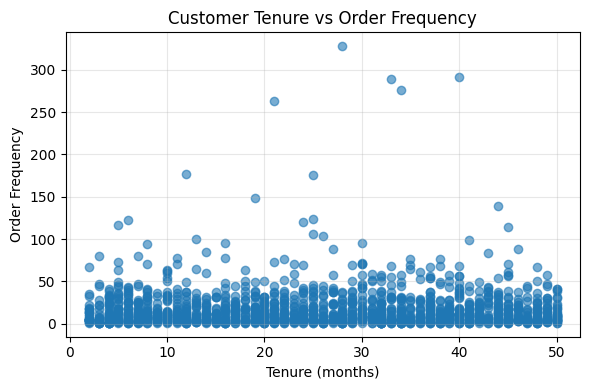

In [262]:
tf = sales.groupby('customerid').agg(
    tenure=('tenure_months','first'),
    freq=('transaction_id','nunique')
)

# 2) Compute Pearson correlation and print with 2-decimal formatting
corr_val = tf['tenure'].corr(tf['freq'])
print(f"Correlation (tenure vs frequency): {corr_val:.2f}")

# 3) Scatter plot
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(tf['tenure'], tf['freq'], alpha=0.6)
ax.set(
    title='Customer Tenure vs Order Frequency',
    xlabel='Tenure (months)',
    ylabel='Order Frequency'
)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 18. Delivery Charges vs Quantity


Correlation: 0.19


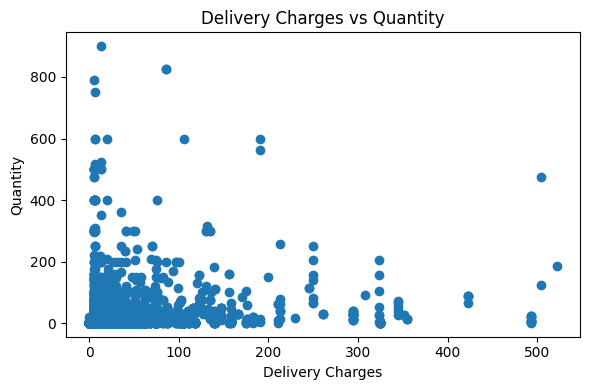

In [263]:
corr_dc = sales[['delivery_charges','quantity']].corr().iloc[0,1]
print(f"Correlation: {corr_dc:.2f}")
fig,ax=plt.subplots(figsize=(6,4))
ax.scatter(sales['delivery_charges'],sales['quantity'])
ax.set(title='Delivery Charges vs Quantity',xlabel='Delivery Charges',ylabel='Quantity')
plt.tight_layout(); plt.show()

## 19. Tax & Delivery Impact on Spending


Pearson r (net_value vs gst_rate):            -0.30
Pearson r (net_value vs delivery_charges):   0.18


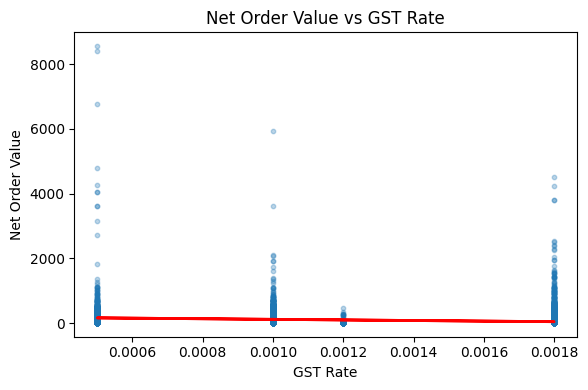

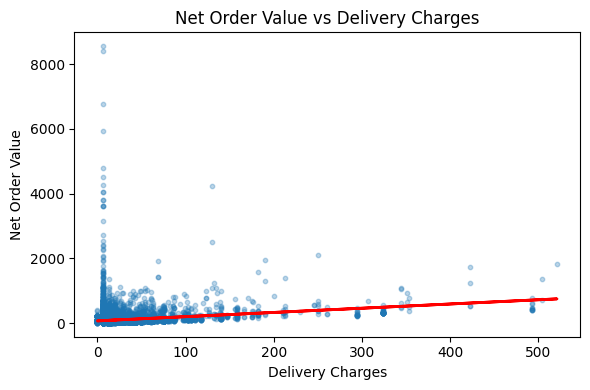

/var/folders/92/bm_nyn89101fck1f72xms5fw0000gn/T/ipykernel_24174/186889563.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_del = sales.groupby('del_bin')['net_value'].mean()


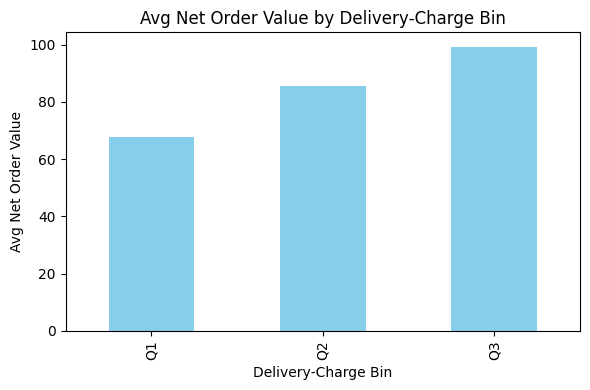

/var/folders/92/bm_nyn89101fck1f72xms5fw0000gn/T/ipykernel_24174/186889563.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_gst = sales.groupby('gst_bin')['net_value'].mean()


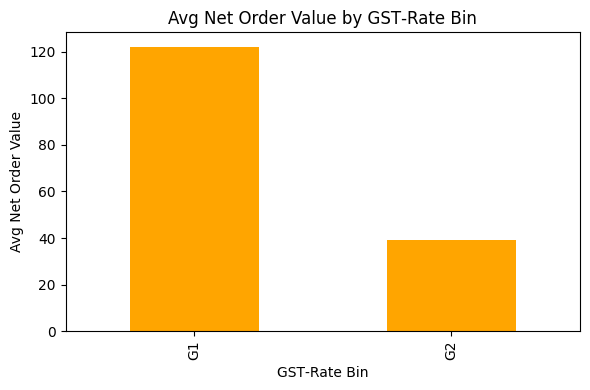

In [264]:
# 1) Pearson correlations
corr_gst = sales['gst_rate'].corr(sales['net_value'])
corr_del = sales['delivery_charges'].corr(sales['net_value'])
print(f"Pearson r (net_value vs gst_rate):            {corr_gst:.2f}")
print(f"Pearson r (net_value vs delivery_charges):   {corr_del:.2f}")

# 2) Scatter + linear trend for gst_rate
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(sales['gst_rate'], sales['net_value'], alpha=0.3, s=10)
m, b = np.polyfit(sales['gst_rate'], sales['net_value'], 1)
ax.plot(sales['gst_rate'], m*sales['gst_rate'] + b, color='red', lw=2)
ax.set(title='Net Order Value vs GST Rate',
       xlabel='GST Rate', ylabel='Net Order Value')
plt.tight_layout()
plt.show()

# 3) Scatter + linear trend for delivery_charges
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(sales['delivery_charges'], sales['net_value'], alpha=0.3, s=10)
m2, b2 = np.polyfit(sales['delivery_charges'], sales['net_value'], 1)
ax.plot(sales['delivery_charges'], m2*sales['delivery_charges'] + b2, color='red', lw=2)
ax.set(title='Net Order Value vs Delivery Charges',
       xlabel='Delivery Charges', ylabel='Net Order Value')
plt.tight_layout()
plt.show()

# 4) Group by delivery‑charge bins using pd.cut with qcut edges
#    a) get bin edges (duplicates dropped)
_, del_edges = pd.qcut(
    sales['delivery_charges'],
    q=4,
    retbins=True,
    duplicates='drop'
)
#    b) create labels
n_del_bins = len(del_edges) - 1
del_labels = [f"Q{i+1}" for i in range(n_del_bins)]
#    c) bin with pd.cut
sales['del_bin'] = pd.cut(
    sales['delivery_charges'],
    bins=del_edges,
    labels=del_labels,
    include_lowest=True
)
#    d) compute and plot
mean_by_del = sales.groupby('del_bin')['net_value'].mean()
fig, ax = plt.subplots(figsize=(6,4))
mean_by_del.plot(kind='bar', ax=ax, color='skyblue')
ax.set(title='Avg Net Order Value by Delivery‑Charge Bin',
       xlabel='Delivery‑Charge Bin', ylabel='Avg Net Order Value')
plt.tight_layout()
plt.show()

# 5) (Optional) Bin GST rate similarly if there’s variation
if sales['gst_rate'].nunique() > 1:
    _, gst_edges = pd.qcut(
        sales['gst_rate'],
        q=4,
        retbins=True,
        duplicates='drop'
    )
    n_gst_bins = len(gst_edges) - 1
    gst_labels = [f"G{i+1}" for i in range(n_gst_bins)]
    sales['gst_bin'] = pd.cut(
        sales['gst_rate'],
        bins=gst_edges,
        labels=gst_labels,
        include_lowest=True
    )
    mean_by_gst = sales.groupby('gst_bin')['net_value'].mean()
    fig, ax = plt.subplots(figsize=(6,4))
    mean_by_gst.plot(kind='bar', ax=ax, color='orange')
    ax.set(title='Avg Net Order Value by GST‑Rate Bin',
           xlabel='GST‑Rate Bin', ylabel='Avg Net Order Value')
    plt.tight_layout()
    plt.show()

## 19. Seasonal Trends by Category


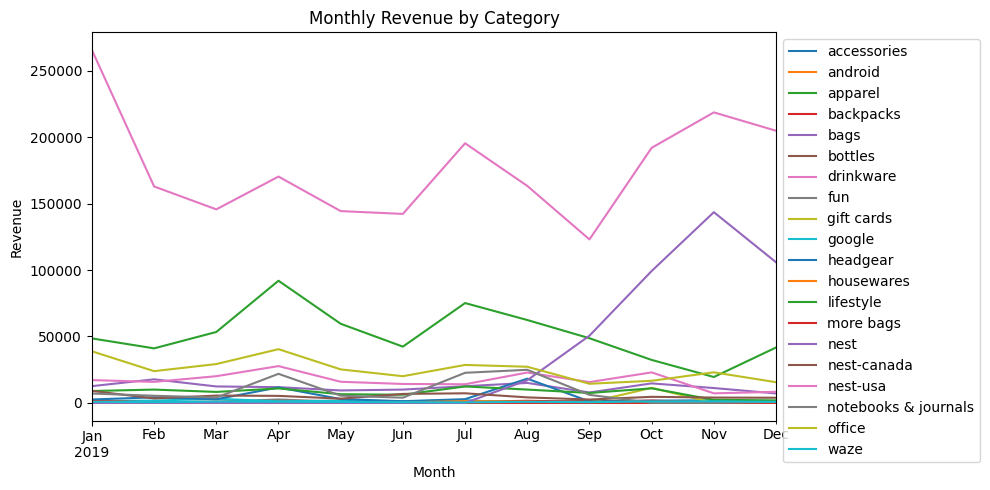

In [265]:
season = sales.groupby(['month','product_category'])['net_revenue'].sum().unstack(fill_value=0)
fig,ax=plt.subplots(figsize=(10,5))
for col in season.columns: season[col].plot(ax=ax)
ax.set(title='Monthly Revenue by Category',xlabel='Month',ylabel='Revenue')
plt.legend(bbox_to_anchor=(1,1)); plt.tight_layout(); plt.show()

## 20. Daily Sales Trends


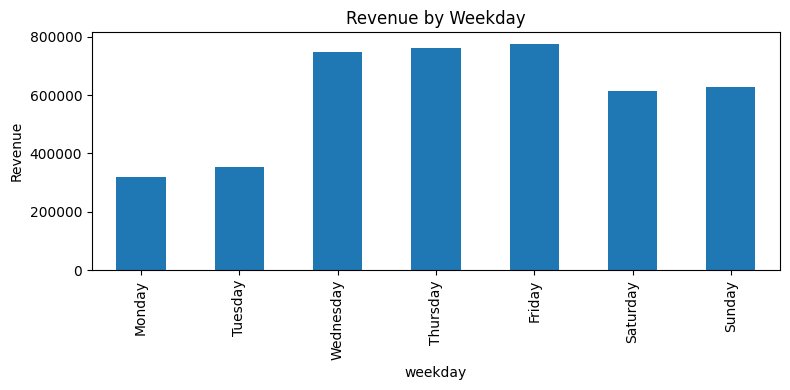

In [266]:
by_day = sales.groupby('weekday')['net_revenue'].sum().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
fig,ax=plt.subplots(figsize=(8,4))
by_day.plot(kind='bar',ax=ax)
ax.set(title='Revenue by Weekday',ylabel='Revenue')
plt.tight_layout(); plt.show()